In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
IN_DIR = "E:\\M2\\result\\20221027\\"
OUT_DIR = "E:\\M2\\result\\20221027\\"
sub_dir_list = "cbi_q_10\\1\\"

In [4]:
time_table = pd.read_csv("time.csv", header=None, index_col=0)
time_table = time_table.values[0, :34].astype(np.int64)

In [5]:
ptv_result = np.zeros((1, 6))

In [6]:
for i in tqdm(range(0, 10900)):
    for j in range(17):
        if time_table[2 * j] <= i < time_table[2 * j + 1]:
            try:
                r = np.loadtxt(OUT_DIR + "ptv\\" + sub_dir_list + f"pp_{i}.csv", delimiter=',', skiprows=1)
            except StopIteration:
                r = None

            if r is None:
                pass
            elif r.ndim == 1:
                if len(r) > 0:
                    r = r[np.newaxis, :]
                    ptv_result = np.vstack([ptv_result, r])

            elif r.ndim == 2:
                ptv_result = np.vstack([ptv_result, r])

100%|██████████| 1089/1089 [00:04<00:00, 232.49it/s]


In [7]:
ptv_result = pd.DataFrame(ptv_result[:, :4], columns=['x', 'y', 'dx', 'dy'])
for row in ptv_result.index:
    if (ptv_result.loc[row] == 0).all():
        ptv_result.drop(row, axis=0, inplace=True)

In [8]:
ptv_result = ptv_result.sort_values(by='y', ascending=True).values

In [9]:
Grid_X, Grid_Y = 204, 120

In [10]:
width, height = 1024, 600

In [11]:
x = np.linspace(0, width, Grid_X)
y = np.linspace(0, height, Grid_Y)
xx, yy = np.meshgrid(x, y)

u = np.zeros([Grid_Y, Grid_X])
v = np.zeros([Grid_Y, Grid_X])

In [12]:
sigma = 1.24 * np.sqrt(height*width / ptv_result.shape[0])

In [13]:
for j in tqdm(range(0, Grid_Y)):
    upper_limit = ptv_result[np.where(ptv_result[:, 1] >= height // Grid_Y * j)]
    upper_bottom_limit = upper_limit[np.where(upper_limit[:, 1] < height // Grid_Y * (j + 1))]

    tmp_y = pd.DataFrame(data=upper_bottom_limit[:, :4], columns=['x', 'y', 'dx', 'dy']).sort_values(by='x', ascending=True).values

    for i in range(0, Grid_X):
        left_limit = tmp_y[np.where(tmp_y[:, 0] >= width // Grid_X * i)]
        left_right_limit = left_limit[np.where(left_limit[:, 0] < width // Grid_X * (i + 1))]
        tmp = left_right_limit

        top_u, top_v = 0, 0
        bottom = 0
        omega = 0

        for k in range(tmp.shape[0]):
            r = np.sqrt((width // Grid_X * (i + 0.5) - tmp[k][0])**2 + (height // Grid_Y * (j + 0.5) - tmp[k][1])**2)
            omega = np.exp(- (r / sigma)**2)

            top_u += omega * tmp[k][2]
            top_v += omega * tmp[k][3]
            bottom += omega

        if omega == 0:
            u[j, i] = np.nan
            v[j, i] = np.nan
        else:
            u[j, i] = top_u / bottom
            v[j, i] = top_v / bottom

100%|██████████| 120/120 [00:02<00:00, 55.24it/s] 


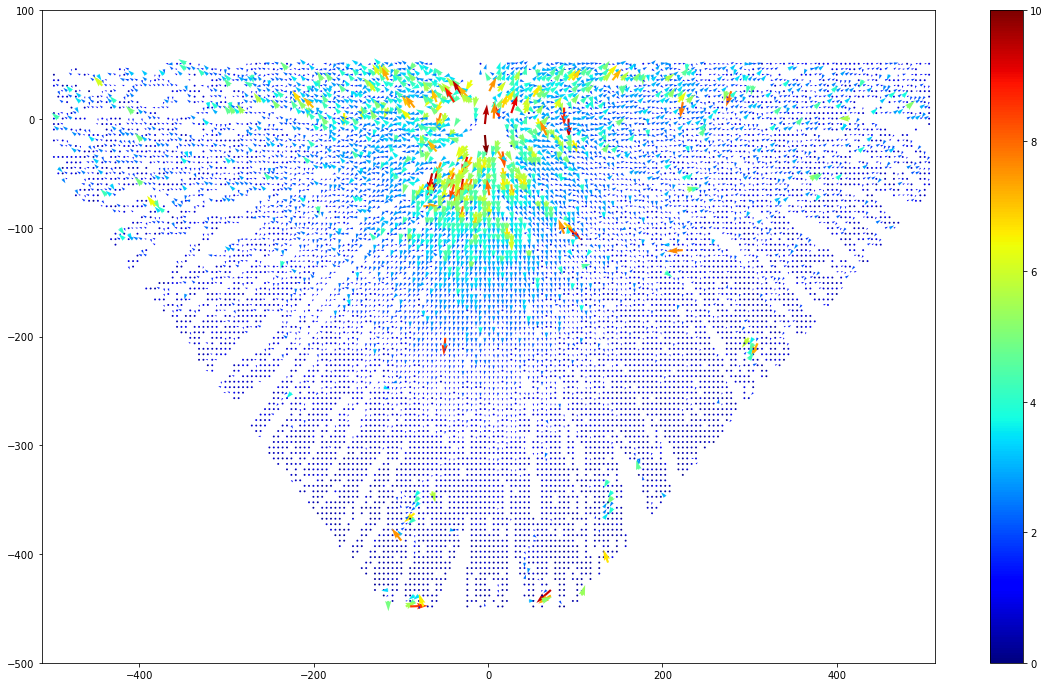

In [14]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim(-512, 512)
plt.ylim(-500, 100)

plt.quiver(xx - 498, 51 - yy, u, -v, np.sqrt(u**2 + v**2), cmap="jet")

plt.colorbar()
plt.clim(0, 10)
plt.show()